# Reconstruction Efficiencies

¿Quién me le habló feo al proceso de reconstrucción?

In [3]:
import sys
sys.path.append('/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/libs')

import crudo
import fit_functions as ff
import h5py
from   iminuit      import Minuit
from   iminuit.cost import LeastSquares
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotting_tools as pt
import tables as tb
import scipy

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data

## Runs Information

In [2]:
# List of high-energy (HE) runs
runs_info = {
                # # Condition 0:  castle = open #
                15062: {"duration": 84783, "OK": 69564, "LOST": 133911, "condition": 0},
                15063: {"duration": 79120, "OK": 65052, "LOST": 124131, "condition": 0},
                15076: {"duration": 69316, "OK": 56775, "LOST": 108095, "condition": 0},
                # # Condition 1:  castle = pclosed & RAS = on #
                15288: {"duration": 87256, "OK": 30201, "LOST": 8397  , "condition": 1},
                15289: {"duration": 82152, "OK": 28180, "LOST": 7884  , "condition": 1},
                15290: {"duration": 61295, "OK": 20931, "LOST": 5915  , "condition": 1},
                # # Condition 2:  castle = pclosed & RAS = off #
                15299: {"duration": 60204, "OK": 18014, "LOST": 8929  , "condition": 2},
                15318: {"duration": 86706, "OK": 28735, "LOST": 10115 , "condition": 2},
                15319: {"duration": 85823, "OK": 27973, "LOST": 10086 , "condition": 2},
                15330: {"duration": 86462, "OK": 28157, "LOST": 10432 , "condition": 2},
                15331: {"duration": 85389, "OK": 27390, "LOST": 9966  , "condition": 2},
                15332: {"duration": 67758, "OK": 22010, "LOST": 8142  , "condition": 2},      # Loosely estimated
                15462: {"duration": 39365, "OK": 12847, "LOST": 4532  , "condition": 2},
                15472: {"duration": 86563, "OK": 28505, "LOST": 10015 , "condition": 2},      # Loosely estimated
                15478: {"duration": 86835, "OK": 28702, "LOST": 9999  , "condition": 2},
                15479: {"duration": 86876, "OK": 28713, "LOST": 10036 , "condition": 2},
                15484: {"duration": 86538, "OK": 28188, "LOST": 10465 , "condition": 2},
                15485: {"duration": 86186, "OK": 28281, "LOST": 10309 , "condition": 2},
                15486: {"duration": 86578, "OK": 28700, "LOST": 10361 , "condition": 2},
                15487: {"duration": 86456, "OK": 28703, "LOST": 9952  , "condition": 2},
                15488: {"duration": 86367, "OK": 28891, "LOST": 10049 , "condition": 2},
                15489: {"duration": 60554, "OK": 20059, "LOST": 7031  , "condition": 2},
                # # Condition 3:  castle = closed & RAS = on #
                15502: {"duration": 85477, "OK": 28287, "LOST": 9564  , "condition": 3},
                15504: {"duration": 85194, "OK": 28297, "LOST": 9537  , "condition": 3},
                15505: {"duration": 86517, "OK": 28632, "LOST": 9725  , "condition": 3},
                15506: {"duration": 84841, "OK": 28438, "LOST": 9603  , "condition": 3},
                15507: {"duration": 55740, "OK": 18569, "LOST": 6149  , "condition": 3},
                15514: {"duration": 59207, "OK": 20054, "LOST": 6646  , "condition": 3},  
                15519: {"duration": 34045, "OK": 11420, "LOST": 3646  , "condition": 3},
                15520: {"duration": 85170, "OK": 28050, "LOST": 9130  , "condition": 3},
                15521: {"duration": 85388, "OK": 28396, "LOST": 8831  , "condition": 3},
                15527: {"duration": 69725, "OK": 23560, "LOST": 7411  , "condition": 3},
                15528: {"duration": 41361, "OK": 13460, "LOST": 4426  , "condition": 3},
                15535: {"duration": 84904, "OK": 28799, "LOST": 9156  , "condition": 3},
                # 15539: {"duration": 56567, "OK": 15618, "LOST": 9586  , "condition": 3},        # NO data
                # 15540: {"duration": 67663, "OK": 22526, "LOST": 7066  , "condition": 3},        # NO data
                # 15541: {"duration": 86630, "OK": 29124, "LOST": 9333  , "condition": 3},        # NO data
            }

## Overall Evolution

First, read the extra information file that has the number of reconstructed events per run.

In [5]:
# Dictionary to store the extra information for each run
Extra_info = {run_id: {'Date_CV': None, 'Date_Err': None, 'Reco_CV': None, 'Reco_Err': None} for run_id in runs_info.keys()}

# .txt file path
extra_file = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Backgrounds/txt/runs_extra_info.txt'

# ----- Load Extra Information ----- #
with open(extra_file, 'r') as f:
    
    for line in f:
        if line.strip():                # Ignore empty lines
            parts = line.split()
            if len(parts) == 4:         # Ensure the line has exactly four values (avoid header)

                run_id, date_cv, date_err, reco_evts = parts
                run_id = int(run_id)

                # Date
                Extra_info[run_id]['Date_CV']  = float(date_cv)
                Extra_info[run_id]['Date_Err'] = float(date_err)

                # Reconstructed events
                reco_evts = int(reco_evts)
                reco_CV, reco_var = scipy.stats.binom.stats(n=runs_info[run_id]['OK'], p=reco_evts/runs_info[run_id]['OK'], moments='mv')
                Extra_info[run_id]['Reco_CV']  = reco_CV
                Extra_info[run_id]['Reco_Err'] = np.sqrt(reco_var)

                # print(f"Run {run_id}: Date CV = {date_cv}, Date Err = {date_err}, Reco CV = {reco_CV}, Reco Err = {Extra_info[run_id]['Reco_Err']:.4f}")

# ----- Important Dates ----- #
# From NEXT-100 operations
CPC_RAS = 1746791100      # Castle = partially closed & RAS = on
CPC     = 1747042200      # Castle = partially closed & RAS = off
CC_RAS  = 1749024786      # Castle = closed & RAS = on

Skipping run 15062 with condition 0
Skipping run 15063 with condition 0
Skipping run 15076 with condition 0

Analysis of 31 runs:
  OK triggers = 779142 || Reconstructed events =  756684
  Total efficiency = 0.9712 ± 0.0138


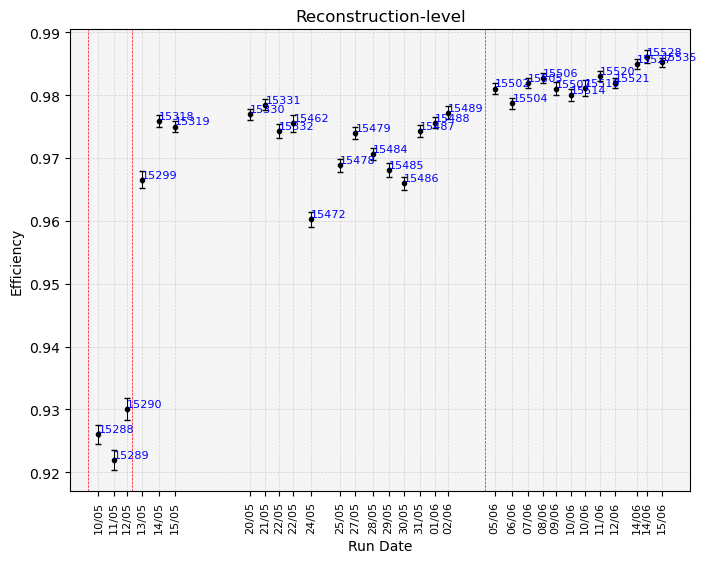

In [14]:
# Global
Date_CV  = []
Date_Err = []
Reco_eff_CV  = []
Reco_eff_Err = []
Run_numbers = []

# Total data numbers
Total_OK   = 0
Total_reco = 0

# ----- Run Loop ----- #
for run_id, entry in runs_info.items():

    # Run information
    run_OK   = entry['OK']
    run_cond = entry['condition']
    run_reco = Extra_info[run_id]['Reco_CV']

    # Skip runs you do not want to include
    if run_cond in [0]:
        print(f"Skipping run {run_id} with condition {run_cond}")
        continue

    Run_numbers.append(run_id)
    Total_OK   += run_OK
    Total_reco += run_reco

    # Date + error for each run
    Date_CV.append(Extra_info[run_id]['Date_CV'])
    Date_Err.append(Extra_info[run_id]['Date_Err'])
    
    # Reco eff + error for each run
    eff_CV, eff_var = ff.efficiency(run_reco, run_OK-run_reco)      # The arguments are (successes, failures)
    Reco_eff_CV.append(eff_CV)
    Reco_eff_Err.append(eff_var)

# ----- Print Total Information ----- #
Total_eff_CV, Total_eff_var = ff.efficiency(Total_reco, Total_OK-Total_reco)
print(f"\nAnalysis of {len(Run_numbers)} runs:")
print(f"  OK triggers = {Total_OK} || Reconstructed events =  {int(Total_reco)}")
print(f"  Total efficiency = {Total_eff_CV:.4f} ± {np.sqrt(Total_eff_var):.4f}")

# ----- Plotting ---- #
plt.figure(figsize=(8, 6))

# Data
plt.errorbar(Date_CV, Reco_eff_CV, xerr=Date_Err, yerr=Reco_eff_Err, fmt='o', ms=3, c='black', ecolor='black', elinewidth=0.75, capsize=2)
for x, y, run_id in zip(Date_CV, Reco_eff_CV, Run_numbers):
    plt.text(x, y, str(run_id), fontsize=8, ha='left', va='bottom', color='blue')       # Run number near the point

# Important dates
plt.axvline(x=CPC_RAS, color='red', linestyle='--', lw=0.5)
# plt.text(CPC_RAS+2e4, 0.81, 'Castle = part. closed & RAS = on', color='red', fontsize=8, ha='left', va='bottom', rotation=90)
plt.axvline(x=CPC, color='red', linestyle='--', lw=0.5)
# plt.text(CPC+2e4, 0.81, 'Castle = part. closed & RAS = off', color='red', fontsize=8, ha='left', va='bottom', rotation=90)
plt.axvline(x=CC_RAS, color='red', linestyle='--', lw=0.5)
# plt.text(CC_RAS+2e4, 0.81, 'Castle = closed & RAS = on', color='red', fontsize=8, ha='left', va='bottom', rotation=90)

# Styling
x_labels = [crudo.epoch_converter(t, h=False) for t in Date_CV]        # Convert x-axis bin edges to readable time format
plt.xlabel('Run Date')
plt.xticks(Date_CV, x_labels, rotation=90, ha='center', fontsize=8)
plt.ylabel('Efficiency')
# plt.ylim(0.8, 1.0)
plt.title('Reconstruction-level')

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

## Irene

Loading dataframes...

## Sohpronia

Loading dataframes...

In [7]:
# Dictionary to store Sophronia filter data
soph_filts = {run_id: {"s12_selector": {}, "valid_hit": {}} for run_id in runs_info.keys()}

# ----- Run Loop ----- #
for run_id, entry in runs_info.items():

    # Run information
    run_cond = entry["condition"]

    # Skip runs you do not want to analyze
    if run_cond in [0]:
        continue
    
    # Load data for each filter type and store it in the corresponding filter dictionary
    soph_filts[run_id]["s12_selector"] = crudo.load_run_data(run_id, id=True, city="sophronia", key="/Filters/s12_selector", verbose=False)[run_id]
    soph_filts[run_id]["valid_hit"]    = crudo.load_run_data(run_id, id=True, city="sophronia", key="/Filters/valid_hit", verbose=False)[run_id]

In [ ]:
# Global
Date_CV  = []
Date_Err = []
Soph_eff_CV  = [[], []]
Soph_eff_Err = [[], []]
Run_numbers = []

# ----- Run Loop ----- #
for run_id, entry in runs_info.items():

    # Run information
    run_cond = entry['condition']

    # Skip runs you do not want to analyze
    if run_cond in [0]:
        print(f"Skipping run {run_id} with condition {run_cond}")
        continue

    Run_numbers.append(run_id)

    # Date + error for each run
    Date_CV.append(Extra_info[run_id]['Date_CV'])
    Date_Err.append(Extra_info[run_id]['Date_Err'])
    

    for j, filtro in enumerate(soph_filts[run_id]):

        # Filter data
        data = soph_filts[run_id][filtro]

        # Filter efficiency
        filt_ok = data.passed.value_counts()[1]
        total   = data.passed.size
        eff_CV, eff_var = ff.efficiency(filt_ok, total-filt_ok)

        Soph_eff_CV[j].append(eff_CV)
        Soph_eff_Err[j].append(eff_var)

Skipping run 15062 with condition 0
Skipping run 15063 with condition 0
Skipping run 15076 with condition 0


The main filter that actually rejects events is the _S12 Selector_
<br>
__How much proportion of the total reconstruction efficiency is due to this filter?__

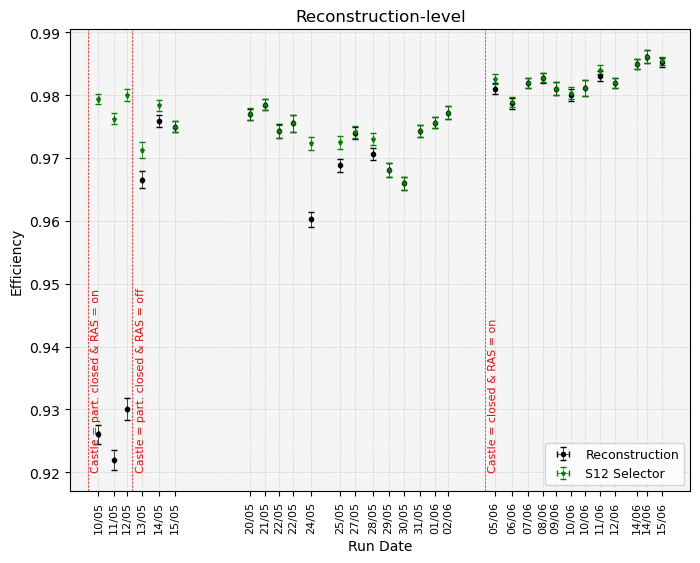

In [15]:
# ----- Plotting ---- #
plt.figure(figsize=(8, 6))

# Data
plt.errorbar(Date_CV, Reco_eff_CV, xerr=Date_Err, yerr=Reco_eff_Err, fmt='o', ms=3, c='black', ecolor='black', capsize=2, elinewidth=0.5, label='Reconstruction')
plt.errorbar(Date_CV, Soph_eff_CV[0], xerr=Date_Err, yerr=Soph_eff_Err[0], fmt='*', ms=3, c='green', ecolor='green', capsize=2, elinewidth=0.5, label='S12 Selector')
# for x, y, run_id in zip(Date_CV, Reco_eff_CV, Run_numbers):
#     plt.text(x, y, str(run_id), fontsize=8, ha='left', va='bottom', color='blue')       # Run number near the point

# Important dates
y_dates = 0.92
plt.axvline(x=CPC_RAS, color='red', linestyle='--', lw=0.5)
plt.text(CPC_RAS+2e4, y_dates, 'Castle = part. closed & RAS = on', color='red', fontsize=8, ha='left', va='bottom', rotation=90)
plt.axvline(x=CPC, color='red', linestyle='--', lw=0.5)
plt.text(CPC+2e4, y_dates, 'Castle = part. closed & RAS = off', color='red', fontsize=8, ha='left', va='bottom', rotation=90)
plt.axvline(x=CC_RAS, color='red', linestyle='--', lw=0.5)
plt.text(CC_RAS+2e4, y_dates, 'Castle = closed & RAS = on', color='red', fontsize=8, ha='left', va='bottom', rotation=90)

# Styling
x_labels = [crudo.epoch_converter(t, h=False) for t in Date_CV]        # Convert x-axis bin edges to readable time format
plt.xticks(Date_CV, x_labels, rotation=90, ha='center', fontsize=8)
plt.xlabel('Run Date')
plt.ylabel('Efficiency')
# plt.ylim(0.75, 1.0)
plt.legend(loc='lower right', fontsize=9)
plt.title('Reconstruction-level')

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

# Simulation

We want to compute a global and a specific, for each isotope ($^{214}Bi$, $^{208}Tl$, $^{60}Co$ and $^{40}K$), reconstruction efficiency.
<br>
The efficiency per isotope is computed as:

$\epsilon_{\text{reco}}^{\text{iso}} = \frac{\sum_{\text{vol}}\epsilon_{\text{reco}}^{\text{iso, vol}} \times N_{\text{reco}}^{\text{iso, vol}}}{\sum_{\text{vol}}N_{\text{reco}}^{\text{iso, vol}}}$

## Preliminary

In [4]:
# MC directory
MC_dir = '/lustre/ific.uv.es/prj/gl/neutrinos/NEXT/MC/NEXT100/Radiogenics/LPR/IC_v2.3.1/NEXUS_v7_08_01/'

# ----- Isotopes ----- #
Isotopes = ['Bi214', 'Tl208', 'Co60', 'K40']
MC_values = {isotope: {} for isotope in Isotopes}

## Sophronia

In [5]:
# ----- Isotopes Loop ----- #
for isotope in Isotopes:

    print(f"\n--- Processing {isotope} ----\n")

    # Isotope directory and sub-folders (volumes)
    isotope_dir = os.path.join(MC_dir, isotope)
    isotope_folders = [folder for folder in os.listdir(isotope_dir) if os.path.isdir(os.path.join(isotope_dir, folder))]
    print(f"Processing information in {len(isotope_folders)} volumes...")

    # ----- Volumes Loop ----- #
    for volume in isotope_folders:

        # Skip active volume. We do not expect background there.
        if volume == 'ACTIVE':
            continue

        # MC Sophronia path
        soph_dir = os.path.join(isotope_dir, volume, 'sophronia')
        # List all .h5 files in the MC Sophronia directory in alphabetical order
        files = sorted([file for file in os.listdir(soph_dir) if file.endswith('.h5')])
        print(f"  {volume} volume: {len(files)} files")

        # Auxiliary variables
        Gen_CV_vol  = 0             # Total generated events in this volume (I use saved_events)
        Reco_CV_vol = 0

        # ----- Sophronias Loop ----- #
        for file in files:

            h5_path = os.path.join(soph_dir, file)

            # Check if the file exists
            if not os.path.exists(h5_path):
                print(f"File {h5_path} does not exist. Skipping {file}.")
                continue

            # Generated events
            df_gen = pd.DataFrame()
            try:
                df_gen = pd.read_hdf(h5_path, key='/MC/configuration')
                saved_events = df_gen.loc[df_gen['param_key'] == 'saved_events', 'param_value'].values[0]
            except: 
                # print(f"  There are no events in {file} (NO /MC/configuration table)")
                saved_events = 0
            Gen_CV_vol += int(saved_events)

            # Reconstructed events
            df_reco = pd.DataFrame()
            try:
                df_reco = pd.read_hdf(h5_path, key='/Filters/s12_selector')
                reco_events = df_reco.passed.value_counts()[1]
            except:
                df_reco = pd.read_hdf(h5_path, key='/RECO/Events')
                reco_events = df_reco.event.nunique()
                # print(f"  From /RECO/Events, we have {reco_events} reconstructed events in {file}")
            Reco_CV_vol += reco_events

        # ----- Don't Store Empty Information! ----- #
        if Gen_CV_vol == 0:
            print(f"  → No generated events found for {isotope} in {volume}. Skipping this volume.")
            continue

        # ----- Efficiency and Reconstructed Events ----- #
        eff_CV, eff_err   = ff.efficiency(Reco_CV_vol, Gen_CV_vol - Reco_CV_vol)
        reco_CV, reco_var = scipy.stats.binom.stats(n=Gen_CV_vol, p=eff_CV, moments='mv')
        print(f"  → Efficiency  = {eff_CV:.4f} ± {eff_err:.4f}")
        print(f"  → Reco events = {reco_CV} ± {np.sqrt(reco_var):.4f}")

        # Dictionary
        MC_values[isotope][volume] = {
                                            'Eff_CV': eff_CV,   'Eff_Err': eff_err,
                                            'Reco_CV': reco_CV, 'Reco_Err': np.sqrt(reco_var)
                                     }


--- Processing Bi214 ----

Processing information in 23 volumes...
  OPTICAL_PAD volume: 24 files
  → Efficiency  = 0.9945 ± 0.0005
  → Reco events = 22239.0 ± 11.0152
  GATE_RING volume: 3 files
  → Efficiency  = 0.9024 ± 0.0041
  → Reco events = 4662.0 ± 21.3267
  LIGHT_TUBE volume: 11 files
  → Efficiency  = 0.9754 ± 0.0007
  → Reco events = 51650.0 ± 35.6636
  PMT volume: 66 files
  → Efficiency  = 0.9928 ± 0.0004
  → Reco events = 45169.0 ± 18.0180
  EDPM_SEAL volume: 156 files
  → Efficiency  = 1.0000 ± 0.0000
  → Reco events = 1.0 ± 0.0000
  PEDESTAL volume: 1000 files
  → Efficiency  = 0.9792 ± 0.0057
  → Reco events = 611.0 ± 3.5678
  EP_COPPER_PLATE volume: 258 files
  → Efficiency  = 0.9938 ± 0.0004
  → Reco events = 35737.0 ± 14.9199
  DB_PLUG volume: 489 files
  → Efficiency  = 0.9377 ± 0.0056
  → Reco events = 1761.0 ± 10.4743
  TP_COPPER_PLATE volume: 7 files
  → Efficiency  = 0.9291 ± 0.0066
  → Reco events = 1403.0 ± 9.9709
  FIELD_RING volume: 88 files
  → Efficiency

## Results

### Efficiency per Isotope

In [6]:
for isotope in Isotopes:

    print(f"\n--- {isotope} ---\n")

    # Auxiliary variables
    num_CV, num_var = 0, 0        # Numerator
    den_CV, den_var = 0, 0        # Denominator

    for volume, values in MC_values[isotope].items():

        print(f"  Volume: {volume} || Efficiency: {values['Eff_CV']:.4f} ± {values['Eff_Err']:.4f} || Reco Events: {values['Reco_CV']} ± {values['Reco_Err']:.4f}")
        
        # Numerator
        num_CV  += values['Eff_CV'] * values['Reco_CV']
        num_var += (values['Reco_CV'] * values['Eff_Err'])**2 + (values['Eff_CV'] * values['Reco_Err'])**2

        # Denominator
        den_CV  += values['Reco_CV']
        den_var += values['Reco_Err']**2

    # Total efficiency
    total_eff_CV  = num_CV / den_CV
    total_eff_var = (num_var / den_CV**2) + ((num_CV**2 * den_var) / den_CV**4)
    print(f"\nTotal efficiency for {isotope} = {total_eff_CV:.4f} ± {np.sqrt(total_eff_var):.4f}")
    print(f"Total reconstructed events for {isotope} = {den_CV} ± {np.sqrt(den_var):.4f}")

    # Store information
    MC_values[isotope]['Total'] = {
                                        'Eff_CV': total_eff_CV,  'Eff_Err': np.sqrt(total_eff_var),
                                        'Reco_CV': den_CV,       'Reco_Err': np.sqrt(den_var)
                                  }


--- Bi214 ---

  Volume: OPTICAL_PAD || Efficiency: 0.9945 ± 0.0005 || Reco Events: 22239.0 ± 11.0152
  Volume: GATE_RING || Efficiency: 0.9024 ± 0.0041 || Reco Events: 4662.0 ± 21.3267
  Volume: LIGHT_TUBE || Efficiency: 0.9754 ± 0.0007 || Reco Events: 51650.0 ± 35.6636
  Volume: PMT || Efficiency: 0.9928 ± 0.0004 || Reco Events: 45169.0 ± 18.0180
  Volume: EDPM_SEAL || Efficiency: 1.0000 ± 0.0000 || Reco Events: 1.0 ± 0.0000
  Volume: PEDESTAL || Efficiency: 0.9792 ± 0.0057 || Reco Events: 611.0 ± 3.5678
  Volume: EP_COPPER_PLATE || Efficiency: 0.9938 ± 0.0004 || Reco Events: 35737.0 ± 14.9199
  Volume: DB_PLUG || Efficiency: 0.9377 ± 0.0056 || Reco Events: 1761.0 ± 10.4743
  Volume: TP_COPPER_PLATE || Efficiency: 0.9291 ± 0.0066 || Reco Events: 1403.0 ± 9.9709
  Volume: FIELD_RING || Efficiency: 0.9867 ± 0.0003 || Reco Events: 168820.0 ± 47.4404
  Volume: SAPPHIRE_WINDOW || Efficiency: 0.9934 ± 0.0002 || Reco Events: 198686.0 ± 36.1299
  Volume: SHIELDING_STEEL || Efficiency: 0.975

### Global Efficiency

In [7]:
# Auxiliary variables
num_CV, num_var = 0, 0        # Numerator
den_CV, den_var = 0, 0        # Denominator

for isotope in Isotopes:

    print(f"--- {isotope} ---")
    eff_CV  = MC_values[isotope]['Total']['Eff_CV'];        eff_err  = MC_values[isotope]['Total']['Eff_Err']
    reco_CV = MC_values[isotope]['Total']['Reco_CV'];       reco_err = MC_values[isotope]['Total']['Reco_Err']
    
    # Numerator
    num_CV  += eff_CV * reco_CV
    num_var += (reco_CV * eff_err)**2 + (eff_CV * reco_err)**2

    # Denominator
    den_CV  += reco_CV
    den_var += reco_err**2

# Total efficiency
total_eff_CV  = num_CV / den_CV
total_eff_var = (num_var / den_CV**2) + ((num_CV**2 * den_var) / den_CV**4)
print(f"\nTotal efficiency for MC = {total_eff_CV:.4f} ± {np.sqrt(total_eff_var):.4f}")
print(f"Total reconstructed events for MC = {den_CV} ± {np.sqrt(den_var):.4f}")

--- Bi214 ---
--- Tl208 ---
--- Co60 ---
--- K40 ---

Total efficiency for MC = 0.9234 ± 0.0003
Total reconstructed events for MC = 2980216.0 ± 477.6587
